# Berlin Airbnb Data Exploration and Pre-Processing

### Context
Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers decide to use Airbnb as their primary accommodation provider. Since its beginning in 2008, Airbnb has seen an enormous growth, with the number of rentals listed on its website growing exponentially each year. In Germany, no city is more popular than Berlin. That implies that Berlin is one of the hottest markets for Airbnb in Europe, with over 22,552 listings as of November 2018.

### Motivation

Airbnb is a internet marketplace for short-term home and apartment rentals. One of the main challanges Airbnb-Hosts face is determining the optimal nightly rent price. Like in any competitive rental-market even small differences in prices can make the difference between optimum occupancy and high earnings, or being priced out of the market.


This Project aims to use machine learning to predict the base price for properties in Berlin, and also to explore the influence of spatial proximity to certain amenities (restaurants, bars, supermarkets), sights and urban green spaces.


### The Data

The dataset used for this project was scraped on November 07th, 2018 and contains detailed listings and review data  of current Airbnb listings in Berlin and can be found [here](https://www.kaggle.com/brittabettendorf/berlin-airbnb-data). In order to use this data set as a basis for a machine learning algorithm, some more data cleaning is necessary. This notebook documents all of the cleaning and pre-processing. <br />

Note: This Notebook is based on [Graciela Carrillos](https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-location-data-5c1e033d0a5a) price predicting approach. He used an OSM pedestrian network to explore the influance of spatial proximity to bars and restaurants on airbnb prices in Edingburgh. 
We will be using a multi-modal-graph network for our location attributes. This way we are meassuring accessebilty in terms of the whole transport network and not only in terms of walkability like he did. By using the same attributes it is possible to compare the to studies (although not optimal, since we use different cities).
 



In [223]:
# Import all important Modules
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
import time
from collections import Counter

In [224]:
raw_df = pd.read_csv(r'./berlin-airbnb-data/listings_summary.csv')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 22552 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,NaN,Within walking distance you'll find the S-Bahn...,Außer deinem Zimmer kannst du noch die Küche u...,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/97d4f6e8-1...,NaN,2986,https://www.airbnb.com/users/show/2986,Michael,2008-09-16,"Berlin, Berlin, Germany",Living with my wife in Berlin. Like travellin...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/50434955-1...,https://a0.muscache.com/im/pictures/50434955-1...,Prenzlauer Berg,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",NaN,Prenzlauer Berg Nordwest,Pankow,Berlin,Berlin,10437,Berlin,"Berlin, Germany",DE,Germany,52.548513,13.404553,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",NaN,$17.00,NaN,NaN,$0.00,$0.00,1,$0.00,2,40,7 weeks ago,t,0,0,0,0,2018-11-07,6,2018-07-04,2018-10-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-1

### Drop initial columns

Natrual Language Processing will not be used in this model. Therefore free text columns will be dropped.

In [225]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

Check for emptiness

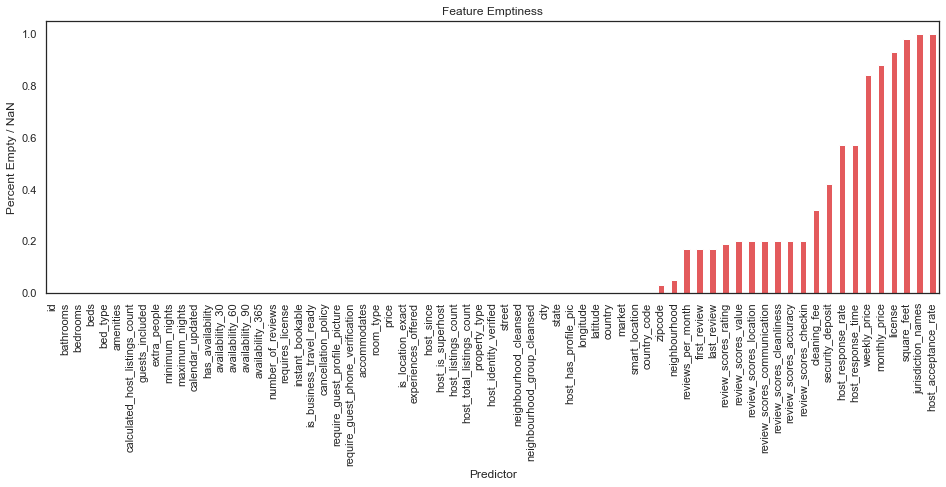

In [226]:
def percent_empty(df):
    bools = df.isnull().tolist()
    percent_empty = float(bools.count(True)) / float(len(bools))

    return percent_empty, float(bools.count(True))


# Store emptiness for all features
emptiness = []

missing_columns = []

# Get emptiness for all features
for i in range(0, df.shape[1]):
    p, n = percent_empty(df.iloc[:, i])
    if n > 0:
        missing_columns.append(df.columns.values[i])
    emptiness.append(round((p), 2))

empty_dict = dict(zip(df.columns.values.tolist(), emptiness))

# Plot emptiness graph
empty = pd.DataFrame.from_dict(empty_dict, orient='index').sort_values(by=0)
ax = empty.plot(kind='bar', color='#E35A5C', figsize=(16, 5))
ax.set_xlabel('Predictor')
ax.set_ylabel('Percent Empty / NaN')
ax.set_title('Feature Emptiness')
ax.legend_.remove()


plt.show()

In [227]:
df.isna().sum()


id                                      0
experiences_offered                     0
host_since                             26
host_response_time                  12894
host_response_rate                  12895
host_acceptance_rate                22552
host_is_superhost                      26
host_listings_count                    26
host_total_listings_count              26
host_has_profile_pic                   26
host_identity_verified                 26
street                                  0
neighbourhood                        1131
neighbourhood_cleansed                  0
neighbourhood_group_cleansed            0
city                                    5
state                                  84
zipcode                               656
market                                 63
smart_location                          0
country_code                            0
country                                 0
latitude                                0
longitude                         

In [228]:
df.drop(['license', 'jurisdiction_names', 'monthly_price', 'weekly_price', 'square_feet','host_acceptance_rate'], axis=1, inplace=True)

# set id as index
df.set_index('id', inplace=True) # ID as index

In [229]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count' 
         ], axis=1, inplace=True)

Drop multiple attributes for property location

In [230]:

df.drop(['zipcode', 'street', 'neighbourhood', 'city', 
         'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

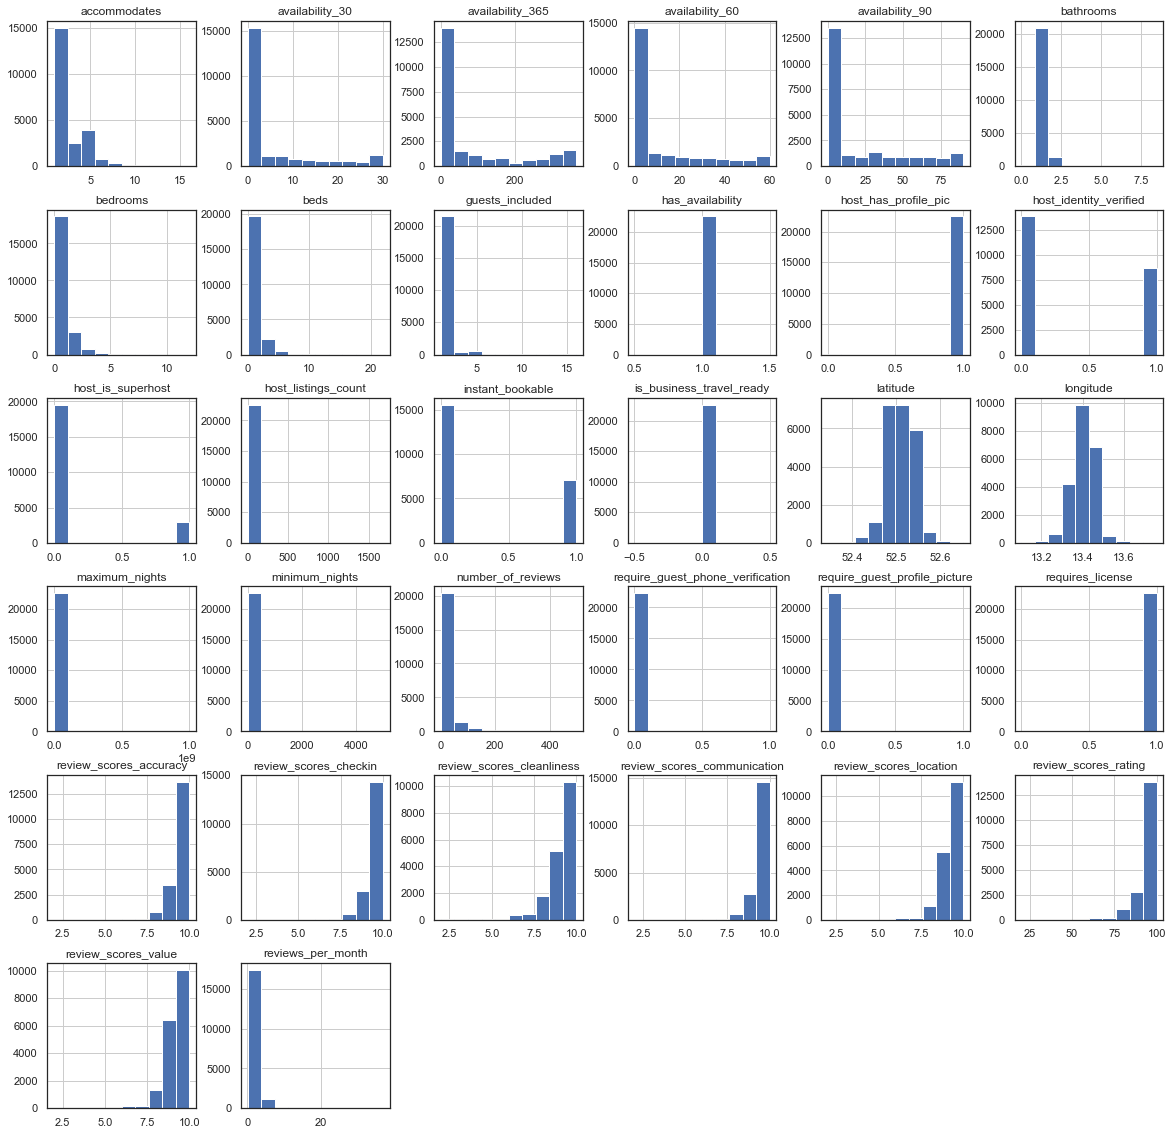

In [231]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

Drop Attributes with only one category

In [232]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 
         'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

clone repo and get feature description

### Individual columns

#### Experiences_offered

Most dont offer any --> drop

In [233]:
df.experiences_offered.value_counts()


none    22552
Name: experiences_offered, dtype: int64

In [234]:
df.drop('experiences_offered', axis=1, inplace=True)


#### host_since

Convert into meassure of the number of days a host has been active on the platform

In [235]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (pd.datetime(2018, 11, 7) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)



Mean days as host: 1346.0
Median days as host: 1289.0


#### host_response_time

Note: Maybe drop this one

In [236]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 12894
Proportion: 57.2%


3914

In [237]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.571745
within an hour        0.225302
within a few hours    0.094315
within a day          0.091344
a few days or more    0.017293
Name: host_response_time, dtype: float64

In [238]:
df.host_response_time.value_counts(normalize=True)


unknown               0.571745
within an hour        0.225302
within a few hours    0.094315
within a day          0.091344
a few days or more    0.017293
Name: host_response_time, dtype: float64

#### host_response_rate

In [239]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 12895
Proportion: 57.2%


In [240]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 92.0
Median host response rate: 100.0
Proportion of 100% host response rates: 73.8%


In [241]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

unknown    12895
100%        7127
50-89%      1706
0-49%        586
90-99%       238
Name: host_response_rate, dtype: int64

#### host_is_superhost

Check how many features are lacking values for host-related attributes and remove those

In [242]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 
                  'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

26

In [244]:
df.dropna(subset=['host_since'], inplace=True)
# drop original column
df.drop(['host_since'], axis=1, inplace=True)

#### property_type

In [245]:
df.property_type.value_counts()


Apartment                 20201
Condominium                 612
Loft                        460
House                       397
Serviced apartment          175
Hostel                      128
Townhouse                    98
Guest suite                  74
Bed and breakfast            64
Guesthouse                   57
Hotel                        50
Other                        47
Boutique hotel               43
Bungalow                     20
Boat                         17
Tiny house                   12
Camper/RV                    11
Houseboat                    11
Villa                        10
Pension (South Korea)         7
Aparthotel                    7
Cabin                         6
Cottage                       4
Resort                        3
Casa particular (Cuba)        2
Castle                        2
Train                         2
Barn                          1
Tipi                          1
Island                        1
In-law                        1
Chalet  

yep, there is some cleaning required....otherwise to many dummies.

Categories: House, Apartment and other

In [246]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Condominium' : 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Chalet': 'House',
    'Houseboat':'House',
    'Castle':'House',
    'Casa particular (Cuba)': 'House'
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
df.property_type.value_counts()

Apartment    21448
House          557
Other          521
Name: property_type, dtype: int64

#### bathrooms, bedrooms and beds

Missing values will be replaced with the median (to avoid strange fractions)


In [247]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

#### bed_type

In [248]:
df.bed_type.value_counts()

Real Bed         21742
Pull-out Sofa      450
Futon              239
Couch               72
Airbed              23
Name: bed_type, dtype: int64

In [249]:
# ...to many dummies...
df.bed_type.replace({
    'Futon':'Real Bed',
    'Pull-out Sofa': 'Couch',
    'Airbed':'Couch'
}, inplace=True)
df.bed_type.value_counts()

Real Bed    21981
Couch         545
Name: bed_type, dtype: int64

#### amenities

Amenities is a list of additional features in the property, i.e. an elevator or pool. Some of those are more imortant than others (i.e. a pool is more likekly to increase the price than a hairdryer). For the purpose of this project, amenities will be extracted based on  research of  Graciela Carrillos.

These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

In [250]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First 

In [251]:
df.shape[1]


43

In [252]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

Amenity features where either the true or the false category contains fewer than 10% of listings will be removed. (No explanatory power)

In [253]:
df.shape[1]


71

In [254]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,44:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,44:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'breakfast', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'secure', 'self_check_in', 'accessible', 'event_suitable']


In [255]:
# list amenitie-dummies
df.columns[44:]


Index(['bed_linen', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods',
       'elevator', 'child_friendly', 'parking', 'host_greeting', 'internet',
       'long_term_stays', 'pets_allowed', 'private_entrance',
       'smoking_allowed'],
      dtype='object')

#### All attributes containing a price

Those need to be converted to integers and the currency sign needs to be removed.

#### Atributes: price, security_deposit, cleaning_fee, extra_people

missing values for security_deposit, cleaning_fee and extra_people is basically the same 0€. Therefore missing values will be replaced with 0


In [256]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [257]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

In [258]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

In [259]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

In [260]:
df.drop('calendar_updated', axis=1, inplace=True)

#### availability 

There are multiple attributes for availability like typ we will only keep avaulability_90

In [261]:

df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

#### first_review and last_review

Basically: To large propotion of the Dataset has missing data for this attribute. But the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet.
Therefore this will be converted to a categorial attribute.


In [262]:

print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 17.3%
Null values in 'review_scores_rating': 19.4%


In [263]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (pd.datetime(2018, 7, 11) - df.first_review).astype('timedelta64[D]')

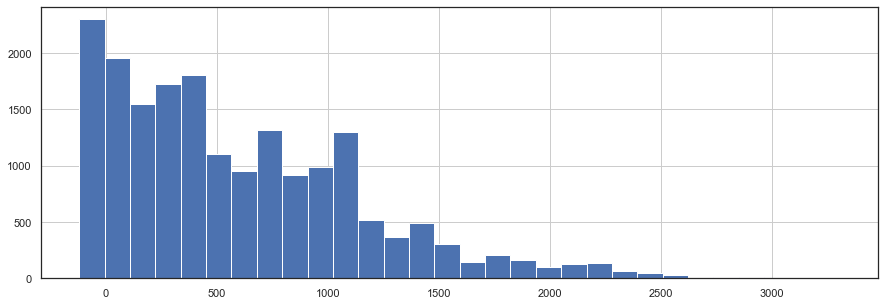

In [264]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [265]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [266]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

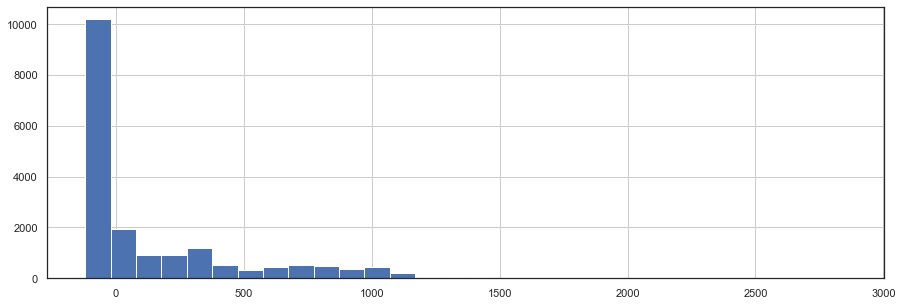

In [267]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (pd.datetime(2018, 7, 11) - df.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [268]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [269]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)
df.drop('first_review', axis=1, inplace=True)

#### check_in_24

In [270]:
df.dtypes

host_response_time               object
host_response_rate               object
host_is_superhost               float64
host_listings_count             float64
host_identity_verified          float64
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
price                             int64
security_deposit                  int64
cleaning_fee                      int64
guests_included                   int64
extra_people                      int64
minimum_nights                    int64
maximum_nights                    int64
availability_90                   int64
number_of_reviews                 int64


In [271]:
df.check_in_24h.fillna("unknown", inplace=True)

In [272]:
df.check_in_24h.value_counts()

unknown    21175
1.0         1351
Name: check_in_24h, dtype: int64

#### review rating columns

As above, listings without reviews will be kept and replaced with unknown. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

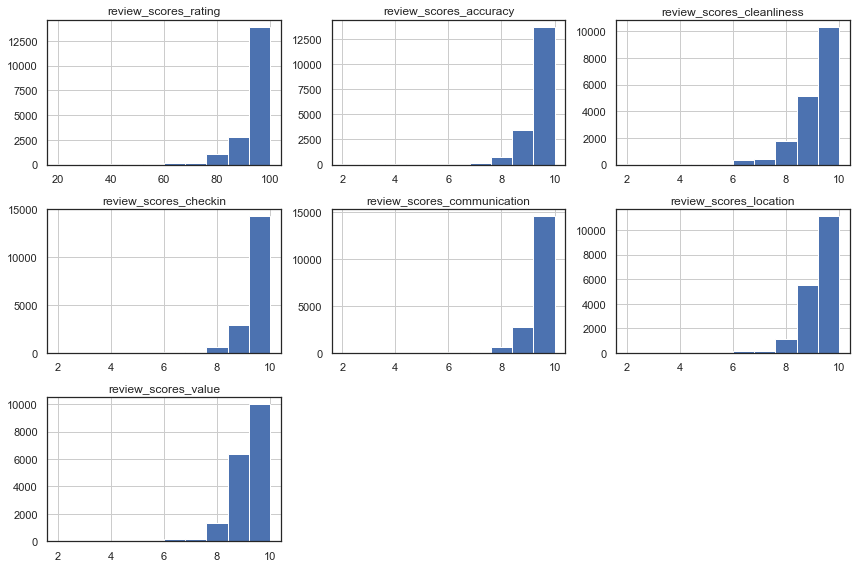

In [273]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [274]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [275]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [276]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

#### cancellation_policy

cleaning required -> less dummies

In [277]:
df.cancellation_policy.value_counts()

flexible                       9083
moderate                       7092
strict_14_with_grace_period    6284
super_strict_30                  53
super_strict_60                  14
Name: cancellation_policy, dtype: int64

In [278]:
df.cancellation_policy.replace({
    'super_strict_30':'strict_14_with_grace_period',
    'super_strict_60':'strict_14_with_grace_period'
},  inplace=True)

In [279]:
df.cancellation_policy.value_counts()

flexible                       9083
moderate                       7092
strict_14_with_grace_period    6351
Name: cancellation_policy, dtype: int64

In [280]:
df.drop(['reviews_per_month'], axis=1, inplace=True)

In [281]:
df.dtypes

host_response_time               object
host_response_rate               object
host_is_superhost               float64
host_listings_count             float64
host_identity_verified          float64
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
price                             int64
security_deposit                  int64
cleaning_fee                      int64
guests_included                   int64
extra_people                      int64
minimum_nights                    int64
maximum_nights                    int64
availability_90                   int64
number_of_reviews                 int64


In [282]:
# save cleaned dataset
listings_cleaned = df.to_csv(r'listings_cleaned.csv', index=id, header=True)


### Categorial Features

Counter({'Friedrichshain-Kreuzberg': 5488, 'Mitte': 4625, 'Pankow': 3539, 'Neukölln': 3494, 'Charlottenburg-Wilm.': 1590, 'Tempelhof - Schöneberg': 1560, 'Lichtenberg': 687, 'Treptow - Köpenick': 595, 'Steglitz - Zehlendorf': 437, 'Reinickendorf': 246, 'Marzahn - Hellersdorf': 141, 'Spandau': 124})


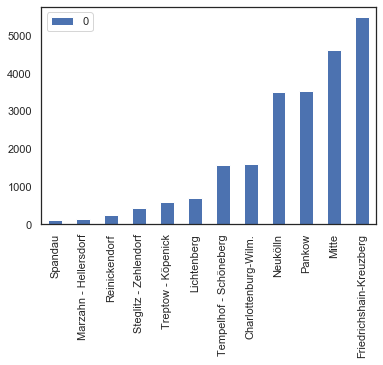

In [283]:
nb_counts = Counter(df.neighbourhood_group_cleansed)
df_nb = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
print(nb_counts)
df_nb.plot(kind='bar')
plt.show()

Counter({'Tempelhofer Vorstadt': 1322, 'Frankfurter Allee Süd FK': 1280, 'Alexanderplatz': 1089, 'Reuterstraße': 999, 'Rixdorf': 880, 'Neuköllner Mitte/Zentrum': 795, 'Brunnenstr. Süd': 773, 'Frankfurter Allee Nord': 735, 'Schillerpromenade': 662, 'südliche Luisenstadt': 642, 'Prenzlauer Berg Nordwest': 622, 'Prenzlauer Berg Südwest': 618, 'Schöneberg-Nord': 567, 'Prenzlauer Berg Süd': 555, 'Wedding Zentrum': 517, 'Moabit West': 489, 'nördliche Luisenstadt': 484, 'Schöneberg-Süd': 474, 'Helmholtzplatz': 459, 'Prenzlauer Berg Nord': 411, 'Südliche Friedrichstadt': 389, 'Moabit Ost': 377, 'Karl-Marx-Allee-Süd': 363, 'Parkviertel': 354, 'Osloer Straße': 346, 'Brunnenstr. Nord': 279, 'Karl-Marx-Allee-Nord': 273, 'Tempelhof': 268, 'Prenzlauer Berg Ost': 241, 'Neu Lichtenberg': 236, 'Regierungsviertel': 213, 'Volkspark Wilmersdorf': 200, 'Tiergarten Süd': 188, 'Pankow Süd': 182, 'Düsseldorfer Straße': 182, 'Weißensee': 179, 'Alt  Treptow': 169, 'Friedenau': 168, 'Neue Kantstraße': 160, 'Kant

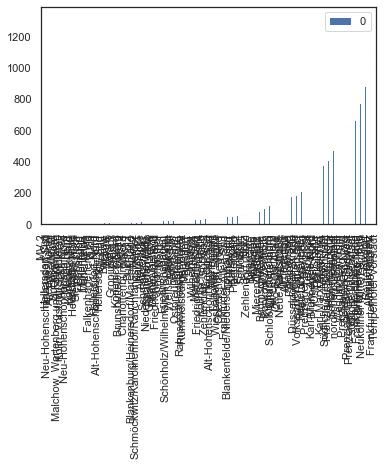

In [284]:
nb_counts = Counter(df.neighbourhood_cleansed)
df_nb = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
print(nb_counts)
df_nb.plot(kind='bar')
plt.show()


yep, we will only keep the neighbourhood_group_cleansed attribute

In [285]:
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

In [286]:
df.dtypes

host_response_time               object
host_response_rate               object
host_is_superhost               float64
host_listings_count             float64
host_identity_verified          float64
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
price                             int64
security_deposit                  int64
cleaning_fee                      int64
guests_included                   int64
extra_people                      int64
minimum_nights                    int64
maximum_nights                    int64
availability_90                   int64
number_of_reviews                 int64
review_scores_rating             object


The machine-learning algorithm only works with numerical data. Therefore we have to transform all of the categorial attributes. This is done with "one hot encoding". 

In [287]:
transformed_df = pd.get_dummies(df)

In [288]:
transformed_df.dtypes

host_is_superhost                     float64
host_listings_count                   float64
host_identity_verified                float64
latitude                              float64
longitude                             float64
                                       ...   
time_since_last_review_1+ year          uint8
time_since_last_review_2-6 months       uint8
time_since_last_review_2-8 weeks        uint8
time_since_last_review_6-12 months      uint8
time_since_last_review_nan              uint8
Length: 110, dtype: object

### Check for multicollinearity of features:

In statistics, multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. 


The seaborn module seems to be broken, therefore we will just drop the Attributes which  Graciela Carrillos identified

In [289]:
pd.set_option('display.max_rows', 3100)

transformed_df.isna().sum()


host_is_superhost                                        0
host_listings_count                                      0
host_identity_verified                                   0
latitude                                                 0
longitude                                                0
accommodates                                             0
bathrooms                                                0
bedrooms                                                 0
beds                                                     0
price                                                    0
security_deposit                                         0
cleaning_fee                                             0
guests_included                                          0
extra_people                                             0
minimum_nights                                           0
maximum_nights                                           0
availability_90                                         

In [290]:
collinearity_df = transformed_df.astype('int64').dtypes

In [70]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [71]:

multi_collinearity_heatmap(collinearity_df, figsize=(20,20))

TypeError: corr() missing 1 required positional argument: 'other'

In [291]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

#### Add the location feature 


The accessibility for the listings was determined in an other notebook. Here we will just merge the two dataframes

In [292]:
access_dir = r'./Berlin_Data/Berlin_Listings_Final.csv'
access_df = pd.read_csv(access_dir)

In [293]:
access_df.drop(access_df.columns.difference(['id','Score_Amenities','Score_Sights', 
                                             'Score_Parks']), axis= 1, inplace=True)

In [294]:
access_df.dtypes

id                   int64
Score_Amenities    float64
Score_Sights       float64
Score_Parks        float64
dtype: object

In [295]:
# merge

merged_df =  pd.merge(transformed_df, access_df, on='id')

In [296]:
merged_df.dtypes

id                                                         int64
host_is_superhost                                        float64
host_listings_count                                      float64
host_identity_verified                                   float64
latitude                                                 float64
longitude                                                float64
accommodates                                               int64
bathrooms                                                float64
price                                                      int64
security_deposit                                           int64
cleaning_fee                                               int64
extra_people                                               int64
minimum_nights                                             int64
maximum_nights                                             int64
availability_90                                            int64
number_of_reviews        

In [297]:
# save dataset

listings_cleaned_score = merged_df.to_csv(r'listings_cleaned_score.csv', index=id, header=True)


### Normalize Dataset

In [298]:
# load dataset
df_final = pd.read_csv('listings_cleaned_score.csv')

In [299]:
df_final.dtypes
df_final.shape[1]

99

In [300]:
numerical_columns = ['Score_Parks','Score_Sights','Score_Amenities','accommodates', 'availability_90', 'bathrooms',
                     'cleaning_fee', 'extra_people', 'host_days_active', 
                     'host_listings_count', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

Other than Score_parks, Score_Sights, availability_90 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation.


Transforms are usually applied so that the data appear to more closely meet the assumptions of a statistical inference procedure that is to be applied, or to improve the interpretability or appearance of graphs.

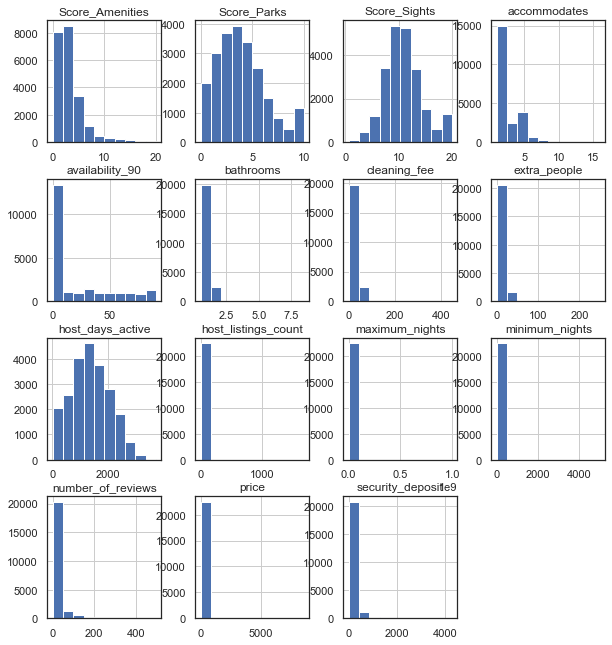

In [301]:
df_final[numerical_columns].hist(figsize=(10,11));


In [302]:

# log transformation
numerical_columns = [i for i in numerical_columns 
                     if i not in ['Score_Sights','Score_Amenities','availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    df_final[col] = df_final[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df_final[col] = np.log(df_final[col])

This appears to have helped some of the distributions, although some (e.g. cleaning_fee, extra_people fee and security_fee) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed (kind of).

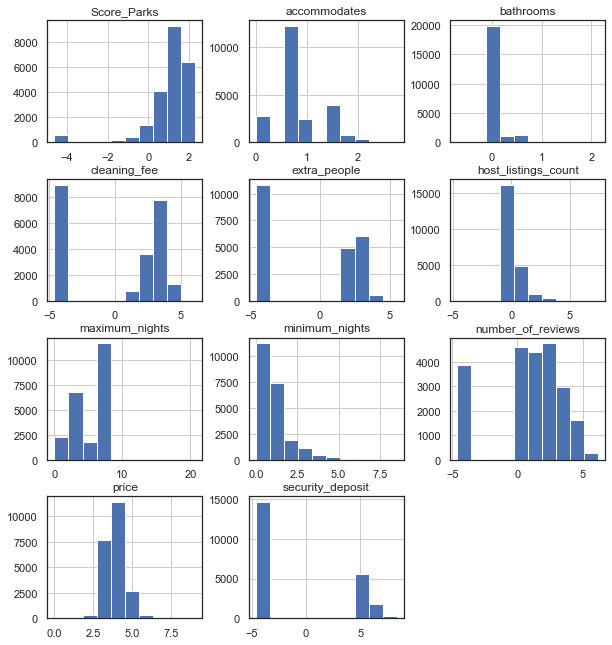

In [303]:
df_final[numerical_columns].hist(figsize=(10,11));

In [304]:

save = df_final.to_csv(r'listings_normalized.csv', index=id, header=True)


#### Get rid of unneccessary attributes

In [305]:
# set index to id an get rid of useless index
df_model = pd.read_csv('listings_normalized.csv', index_col=2)
df_model.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis =1, inplace = True)

df_model.head()


,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,instant_bookable,host_days_active,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,smoking_allowed,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,neighbourhood_group_cleansed_Charlottenburg-Wilm.,neighbourhood_group_cleansed_Friedrichshain-Kreuzberg,neighbourhood_group_cleansed_Lichtenberg,neighbourhood_group_cleansed_Marzahn - Hellersdorf,neighbourhood_group_cleansed_Mitte,neighbourhood_group_cleansed_Neukölln,neighbourhood_group_cleansed_Pankow,neighbourhood_group_cleansed_Reinickendorf,...,neighbourhood_group_cleansed_Steglitz - Zehlendorf,neighbourhood_group_cleansed_Tempelhof - Schöneberg,neighbourhood_group_cleansed_Treptow - Köpenick,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Shared room,bed_type_Couch,bed_type_Real Bed,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_communication_0-8/10,review_scores_communication_10/10,review_scores_communication_9/10,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,check_in_24h_1.0,check_in_24h_unknown,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months,Score_Amenities,Score_Sights,Score_Parks
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,1.0,1.386294,1.0,52.534537,13.402557,1.098612,0.0,4.094345,5.298317,3.401197,3.332205,1.386294,7.025538,51,4.770685,0,3733.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,2.011,10.177,1.111199
2695,0.0,0.000000,1.0,52.548513,13.404553,0.693147,0.0,2.833213,-4.605170,-4.605170,-4.605170,0.693147,3.688879,0,1.791759,0,3704.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,3.212,14.514,1.491105
3176,0.0,0.000000,1.0,52.534996,13.417579,1.386294,0.0,4.499810,5.298317,3.912023,2.995732,4.127134,7.025538,0,4.962845,1,3671.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0.626,11.891,0.753301
3309,0.0,0.000000,1.0,52.498855,13.349065,0.693147,0.0,3.258097,5.521461,3.401197,2.890372,1.609438,5.886104,22,3.218876,0,3652.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,2.454,10.662,1.144223
7071,1.0,0.000000,1.0,52.543157,13.415091,0.693147,0.0,3.737670,-4.605170,-4.605170,3.178054,0.69

In [307]:
df_model.dtypes

host_is_superhost                                        float64
host_listings_count                                      float64
host_identity_verified                                   float64
latitude                                                 float64
longitude                                                float64
accommodates                                             float64
bathrooms                                                float64
price                                                    float64
security_deposit                                         float64
cleaning_fee                                             float64
extra_people                                             float64
minimum_nights                                           float64
maximum_nights                                           float64
availability_90                                            int64
number_of_reviews                                        float64
instant_bookable         

In [308]:
df_model.drop(['longitude', 'latitude'], axis=1, inplace =True)

In [309]:
listings_model = df_model.to_csv('listings_model.csv', index=id, header=True)